<a href="
https://colab.research.google.com/drive/1uhuvoJViyXdhckE7EYHNSXchm9nzAMU2?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>



In [ ]:
 !pip install scanpy
 !pip install -Uq wandb
 %matplotlib inline
 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [ ]:
!python -m pip uninstall matplotlib -Y
!pip install matplotlib==3.1.3


Usage:   
  /usr/bin/python3 -m pip uninstall [options] <package> ...
  /usr/bin/python3 -m pip uninstall [options] -r <requirements file> ...

no such option: -Y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scanpy 1.9.1 requires matplotlib>=3.4, but you have matplotlib 3.1.3 which is incompatible.


In [ ]:
import os


In [ ]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [ ]:
!mkdir /content/gdrive/MyDrive/scintegration/checkpoints

mkdir: cannot create directory ‘/content/gdrive/MyDrive/scintegration/checkpoints’: File exists


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import scanpy as sc
import plotly.express as px
import plotly.io as pio
import sklearn.preprocessing



pio.renderers.default = "colab"
torch.autograd.set_detect_anomaly(True)

In [ ]:
import platform
platform.platform()
if torch.cuda.is_available:
     device = torch.device("cuda:0")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
scdata = sc.read_h5ad("/content/gdrive/MyDrive/scintegration/GEX.h5ad")


In [ ]:
scdata.obs.batch

TAGTTGTCACCCTCAC-1-s1d1     s1d1
CTATGGCCATAACGGG-1-s1d1     s1d1
CCGCACACAGGTTAAA-1-s1d1     s1d1
TCATTTGGTAATGGAA-1-s1d1     s1d1
ACCACATAGGTGTCCA-1-s1d1     s1d1
                            ... 
AAACCGCGTTTGAGGC-12-s4d9    s4d9
TGACTTAAGTTCCCGT-12-s4d9    s4d9
GCTGTACCACCGTTCC-12-s4d9    s4d9
ACACTTGCAACTAGAA-12-s4d9    s4d9
CACTTAAAGTCTGGGC-12-s4d9    s4d9
Name: batch, Length: 69249, dtype: category
Categories (13, object): ['s1d1', 's1d2', 's1d3', 's2d1', ..., 's3d10', 's4d1', 's4d8', 's4d9']

In [ ]:
scdata.shape

(69249, 13431)

In [ ]:
# sc.pp.log1p(scdata)

In [ ]:
class GEX_Dataset(torch.utils.data.Dataset):
    
      def __init__(self, data,  scaler = None, cat_var = None, label_encoder =None):
          
            self.data = data
            
            # we need to work with the dense matrix
            self.values = data.X.todense()
            
            self.cat_var = cat_var
            
            if label_encoder == "numeric":
            # numerically encode the labels
              cat_var_data =  torch.tensor(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]))
            
            elif label_encoder == "range_map":
              cat_var_data =  sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var])
              cat_var_data = cat_var_data.reshape(-1, 1) 
              cat_var_data = torch.tensor(sklearn.preprocessing.MinMaxScaler().fit_transform(cat_var_data))

            elif label_encoder == "one_hot":
              cat_var_data =  torch.tensor(sklearn.preprocessing.LabelEncoder().fit_transform(self.data.obs[self.cat_var]))
              cat_var_data = cat_var_data.reshape(-1, 1)
              cat_var_data = sklearn.preprocessing.OneHotEncoder().fit_transform(cat_var_data).toarray()
              cat_var_data = torch.tensor(cat_var_data)
              



            self.cat_var_data = torch.tensor(cat_var_data)
            
            # scale the data according to user inpt to scaler argument
            if scaler == "Standard":
                self.scaled_values = torch.tensor(sklearn.preprocessing.StandardScaler().fit_transform(self.values))
            elif scaler == "MinMax":
                self.scaled_values = torch.tensor(sklearn.preprocessing.MinMaxScaler().fit_transform(self.values))
            else:
                self.scaled_values = torch.tensor(self.values)
                
    #   return the number of genes when called 
             
      @property
      def n_features(self):
          return self.values.shape[1]

      @property
      def n_catagories(self):
         if self.cat_var_data.shape[1] == 1:
          return len(self.cat_var_data.unique())
        
      
          
          
    #  A dataset class needs the following two methods to work with the dataloader class     
          
    #   return the number of cells when called
      def __len__(self):
          return len(self.data)
    
    #  return an individual cell and its label when called
      def __getitem__(self, idx):
           return self.scaled_values[idx], self.cat_var_data[idx]

    

In [ ]:
scdata
        

AnnData object with n_obs × n_vars = 69249 × 13431
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [ ]:
GEX_Dataset = GEX_Dataset(scdata, scaler = "Standard", cat_var = "batch", label_encoder = "range_map")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning:

np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html



In [ ]:
GEX_Dataset[10000]

(tensor([-0.0830, -0.1486, -0.1304,  ...,  0.3184, -0.1996, -0.0618]),
 tensor([0.0833], dtype=torch.float64))

In [ ]:
input_size = GEX_Dataset.n_features
hidden_size = 128 # hidden dimension
latent_size = 16  # latent vector dimension


batch_size = 256
epochs = 30
lr = 1e-3
 
encoder_train_loss = []
decoder_train_loss = []
classifier_train_loss = []

log_interval = 20
checkpoints = "/content/gdrive/MyDrive/scintegration/checkpoints"

In [ ]:
GEX_Dataset.n_features


13431

In [ ]:
GEX_Dataset[0][1]

tensor([0.], dtype=torch.float64)

In [ ]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder, self).__init__()
        self.efc1 = nn.Linear(input_size, hidden_size)
        self.efc2 = nn.Linear(hidden_size, hidden_size)
        self.efc3_mu = nn.Linear(hidden_size, latent_size)
        self.efc3_sigma = nn.Linear(hidden_size, latent_size)
        
    def encode(self, x):
        x = self.efc1(x)
        x = F.relu(x)
        x = self.efc2(x)
        x = F.relu(x)
        mu = self.efc3_mu(x)
        sigma = self.efc3_sigma(x)
        return((mu,sigma))
        

In [ ]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.dfc1 = nn.Linear(latent_size, hidden_size)
        self.dfc2 = nn.Linear(hidden_size, hidden_size)
        self.dfc3 = nn.Linear(hidden_size, input_size)
        
    def decode(self, x):
        x = self.dfc1(x)
        x = F.relu(x)
        x = self.dfc2(x)
        x = F.relu(x)
        x = self.dfc3(x)
        x = F.sigmoid(x)
        return(x)

In [ ]:
class classifier(nn.Module):
    def __init__(self):
        super(classifier, self).__init__()
        self.cfc1 = nn.Linear(latent_size, 20)
        self.cfc2 = nn.Linear(20, 1)
        
    def classify(self, x):
        x = self.cfc1(x)
        x = F.relu(x)
        x = self.cfc2(x)
        return(x)

In [ ]:
GEX_dataloader = DataLoader(GEX_Dataset, batch_size=batch_size, shuffle=True)
GEX_dataloader_test = DataLoader(GEX_Dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class VAEGAN(nn.Module):
    def __init__(self):
        super(VAEGAN, self).__init__()
        self.encoder = encoder()
        self.decoder = decoder()
        self.classifier = classifier()
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return(mu + eps*std)

    # def normalize(z, spherical):
    #     """normalize to unit length"""
    #     if spherical:
    #         if len(z.shape) == 4:
    #             z = z / z.view(len(z), -1).norm(dim=-1)[:, None, None, None]
    #         else:
    #             z = z / z.view(len(z), -1).norm(dim=1, keepdim=True)
    #         return z
    #     else:
    #         return z

    def sample(self, z):
        return(self.decoder.decode(z))
    
    def classify(self, z):
        return(self.classifier.classify(z))

    def forward(self, x):
        mu, sigma = self.encoder.encode(x)
        z = self.reparameterize(mu, sigma)
        x_hat = self.decoder.decode(z)
        y_hat = self.classifier.classify(z)
        return(x_hat, y_hat, mu, sigma)
    
    
    
      

In [ ]:

def get_VAE_loss(vaegan, data):
    mu, sigma = vaegan.encoder.encode(data)
    z = vaegan.reparameterize(mu, sigma)
    x_hat = vaegan.decoder.decode(z)
    BCE = F.binary_cross_entropy(x_hat, data, reduction='sum')
    KLD = -0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma))
    vae_loss = (BCE + KLD)
    return(BCE + KLD)


In [ ]:
def get_classifier_loss(vaegan, data, label):
    mu, sigma = vaegan.encoder.encode(data)
    z =  vaegan.reparameterize(mu, sigma)
    y_hat = vaegan.classifier.classify(z.detach())

    pred_diff = label - y_hat
    classifier_loss = F.binary_cross_entropy_with_logits(pred_diff, torch.zeros_like(y_hat), reduction = 'sum')
    # real = F.binary_cross_entropy_with_logits(pred_diff, torch.ones_like(label), reduction = 'sum')

    # classifier_loss = (fake + real) / 2
    return classifier_loss


In [ ]:
def get_adversarial_encoder_loss(vaegan, data, label):
    mu, logvar = vaegan.encoder.encode(data)
    z = vaegan.reparameterize(mu, logvar)
    y_hat = vaegan.classifier.classify(z)
    pred_diff = label - y_hat
    encoder_ad_loss = F.binary_cross_entropy_with_logits(pred_diff, torch.ones_like(label), reduction = 'sum')
    return encoder_ad_loss

In [ ]:
def get_vaegan_loss(vaegan, data, label):
    classifier_loss = get_classifier_loss(vaegan, data, label)
    mu, sigma = vaegan.encoder.encode(data)
    z = vaegan.reparameterize(mu, sigma)
    x_hat = vaegan.decoder.decode(z)
    BCE_x = F.binary_cross_entropy(x_hat, data, reduction='sum')
    y_hat = vaegan.classifier.classify(z.detach())
    pred_diff = label - y_hat
    BCE_y = F.binary_cross_entropy_with_logits(pred_diff, torch.zeros_like(y_hat), reduction = 'sum')

    BCE = (BCE_x + BCE_y)/2
    KLD = -0.5 * torch.sum(1 + sigma - mu.pow(2) - torch.exp(sigma))
    return(BCE + KLD)



  
  

In [ ]:
def init_layers(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.uniform_(layer.weight -0.08, 0.08)

In [ ]:
VAEGAN = VAEGAN()
VAEGAN.apply(init_layers)
VAEGAN = VAEGAN.to(device)
VAEGAN.train()

vaegan = VAEGAN

In [ ]:
optimizer_encoder = optim.Adam(VAEGAN.encoder.parameters(), lr=lr)

optimizer_decoder = optim.Adam(VAEGAN.decoder.parameters(), lr=lr)

optimizer_classifier = optim.Adam(VAEGAN.classifier.parameters(), lr=lr)
	


In [ ]:
print(torch.__version__)

1.12.1+cu113


In [ ]:
vae_loss_list = []
classifier_loss_list = []
encoder_ad_loss_list = []




for epoch in range(epochs+1):
  if epoch < 5:
    for batch_idx, (data, label) in enumerate(GEX_dataloader):
        data = data.to(device)
        label = label.to(device)

        VAEGAN.zero_grad()

        vae_loss = get_VAE_loss(vaegan, data)

        vae_loss_list.append(vae_loss.item())

        vae_loss.backward(retain_graph=True, inputs=list(VAEGAN.encoder.parameters()))
        vae_loss.backward(retain_graph=True, inputs=list(VAEGAN.decoder.parameters()))
        optimizer_encoder.step()
        optimizer_decoder.step()

        VAEGAN.zero_grad()

        if batch_idx % log_interval == 0: 
          print(f"Train epoch {epoch} [{batch_idx*len(data)}/{len(GEX_dataloader.dataset)}], VAE Loss: {vae_loss.item():.6f}" )



  else:
      for batch_idx, (data, label) in enumerate(GEX_dataloader):
        data = data.to(device)
        label = label.to(device)
        VAEGAN.zero_grad()
        # vae_loss = get_vaegan_loss(vaegan, data, label)
        vae_loss = get_VAE_loss(vaegan, data)
        vae_loss_list.append(vae_loss.item())

        vae_loss.backward(retain_graph=True, inputs=list(VAEGAN.encoder.parameters()))
        vae_loss.backward(retain_graph=True, inputs=list(VAEGAN.decoder.parameters()))
        optimizer_encoder.step()
        optimizer_decoder.step()

        VAEGAN.zero_grad()
        classifier_loss = get_classifier_loss(vaegan, data, label)
        classifier_loss_list.append(classifier_loss.item())

        encoder_ad_loss = get_adversarial_encoder_loss(vaegan, data, label)
        encoder_ad_loss_list.append(encoder_ad_loss.item())

        classifier_loss.backward(retain_graph=True, inputs=list(VAEGAN.classifier.parameters()))
        encoder_ad_loss.backward(inputs=list(VAEGAN.encoder.parameters()))

        optimizer_classifier.step()
        optimizer_encoder.step()


        
        if batch_idx % log_interval == 0: 
          print(f"Train epoch {epoch} [{batch_idx*len(data)}/{len(GEX_dataloader.dataset)}] VAE Loss: {vae_loss.item():.6f}, Classifier Loss {classifier_loss.item():.6f}")
                # ,  adversarial_encoder_loss {encoder_ad_loss.item():.6f}")
		  
  torch.save(VAEGAN.state_dict(), os.path.join(checkpoints, f'VAEGAN_epoch_{epoch}.pt'))
            
        
        
        
        
  



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Train epoch 0 [0/69249], VAE Loss: 2387150.250000
Train epoch 0 [5120/69249], VAE Loss: -2906883.250000
Train epoch 0 [10240/69249], VAE Loss: -5674730.500000
Train epoch 0 [15360/69249], VAE Loss: -5803257.500000
Train epoch 0 [20480/69249], VAE Loss: -6329441.500000
Train epoch 0 [25600/69249], VAE Loss: -5955851.000000
Train epoch 0 [30720/69249], VAE Loss: -5825757.500000
Train epoch 0 [35840/69249], VAE Loss: -8602239.000000
Train epoch 0 [40960/69249], VAE Loss: -7409555.000000
Train epoch 0 [46080/69249], VAE Loss: -7705528.500000
Train epoch 0 [51200/69249], VAE Loss: -7153527.500000
Train epoch 0 [56320/69249], VAE Loss: -9189933.000000
Train epoch 0 [61440/69249], VAE Loss: -8741643.000000
Train epoch 0 [66560/69249], VAE Loss: -9343003.000000
Train epoch 1 [0/69249], VAE Loss: -8828433.000000
Train epoch 1 [5120/69249], VAE Loss: -8397235.000000
Train epoch 1 [10240/69249], VAE Loss: -8620955.000000
Train epoch 1 [15360/69249], VAE Loss: -10672534.000000
Train epoch 1 [20480

In [ ]:
def load_checkpoint(model, filename):
    print(f'Loading checkpoint {filename} for model {model}')
    model.load_state_dict(torch.load(filename))
    return model

In [ ]:
def checkpoint_to_viz(checkpoint_path, viz_path, model, dataloader, device):
    model = load_checkpoint(model, checkpoint_path)
    model.eval()
    embeddings, labels = get_embeddings(model, dataloader, device)
    scdata.obsm["VAEGAN_z"] = embeddings
    sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
    sc.tl.umap(scdata, min_dist=0.3)
    sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
    sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')
    # plt.savefig(viz_path)

In [ ]:
def get_embeddings(VAEGAN, dataloader, device):
    with torch.no_grad():
        embeddings = []
        labels = []
        for batch, label in dataloader:
            batch = batch.to(device)
            x_hat, y_hat, mu, sigma = VAEGAN(batch)
            embeddings.append(mu.cpu().numpy())
            labels.append(label.cpu().numpy())
        embeddings = np.concatenate(embeddings)
        labels = np.concatenate(labels)
        return embeddings, labels

In [ ]:
# def decode_embeddings(VAEGAN, embeddings):
#     with torch.no_grad():
#         embeddings = torch.tensor(embeddings).to(device)
#         x_gen = VAEGAN.decoder.decode(embeddings)
#         return x_gen.cpu().numpy()
# scdata.obsm["VAEGAN_x_hat"] = decode_embeddings(VAEGAN, embeddings)
# sc.pp.neighbors(scdata, use_rep="VAEGAN_x_hat", n_neighbors=30)
# sc.tl.umap(scdata, min_dist=0.3)
# sc.pl.umap(scdata, color=["batch", "cell_type"])

In [ ]:
# scdata.obsm["VAEGAN_x_hat"] = decode_embeddings(VAEGAN, embeddings)

In [ ]:
# sc.pp.neighbors(scdata, use_rep="VAEGAN_x_hat", n_neighbors=30)

In [ ]:
# sc.tl.umap(scdata, min_dist=0.3)

In [ ]:
# sc.pl.umap(scdata, color=["batch", "cell_type"])

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_8.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


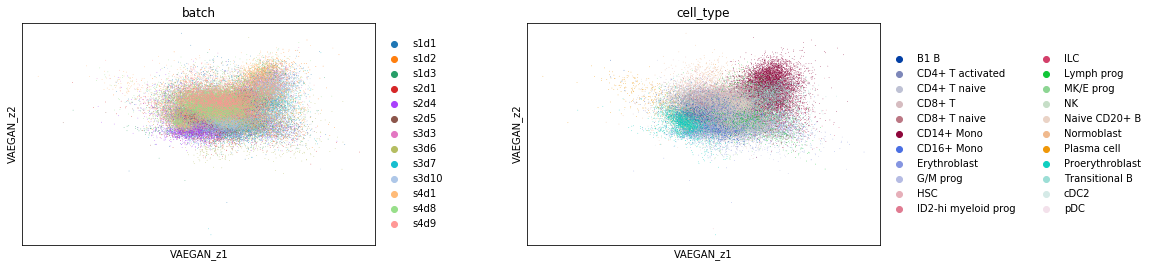

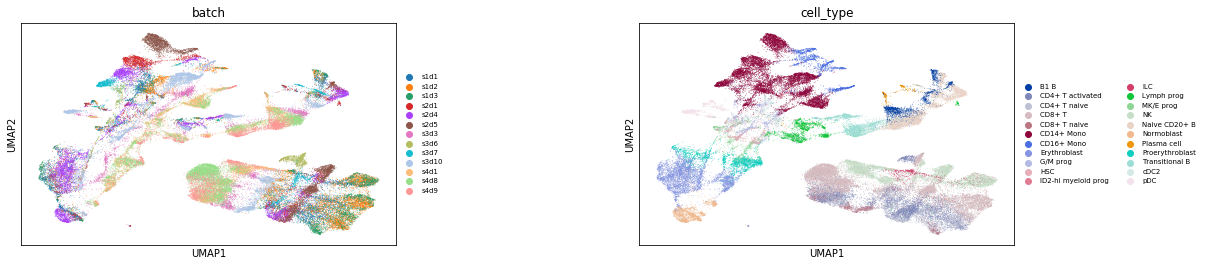

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_8.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_10.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



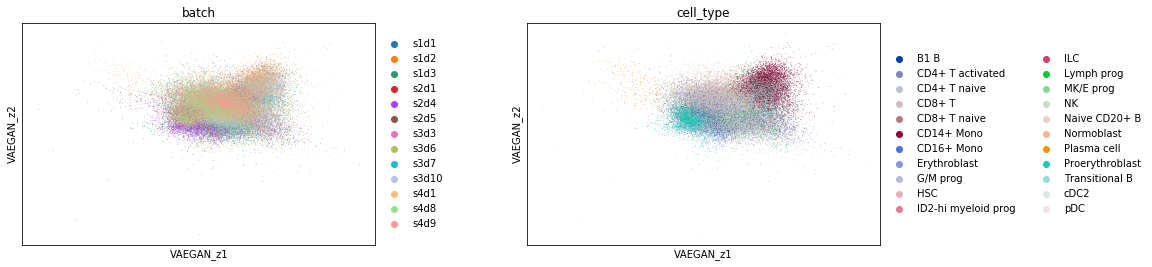

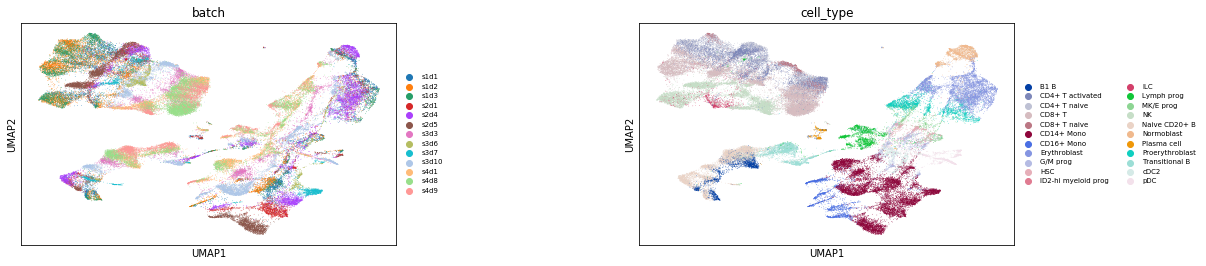

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_10.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_12.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



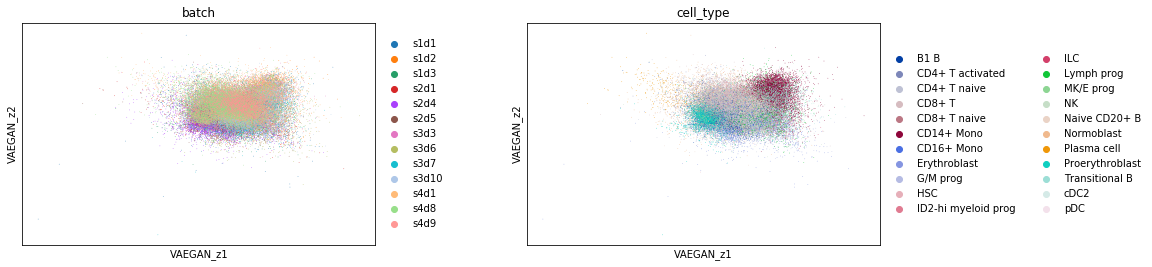

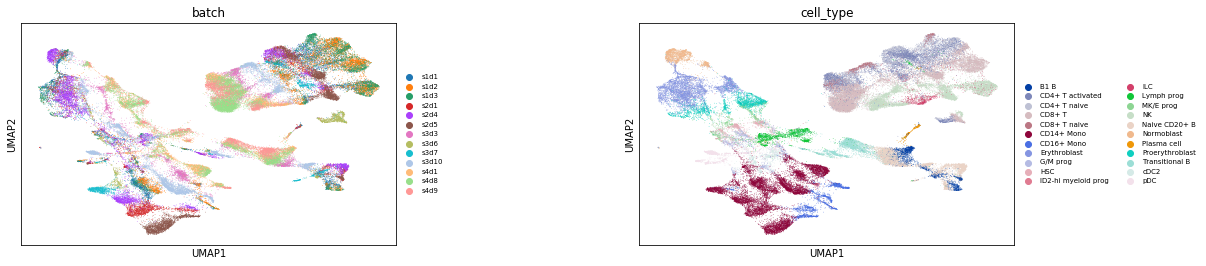

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_12.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_15.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



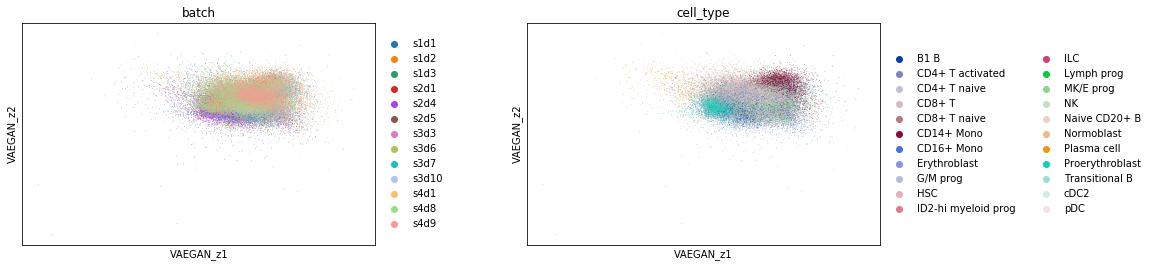

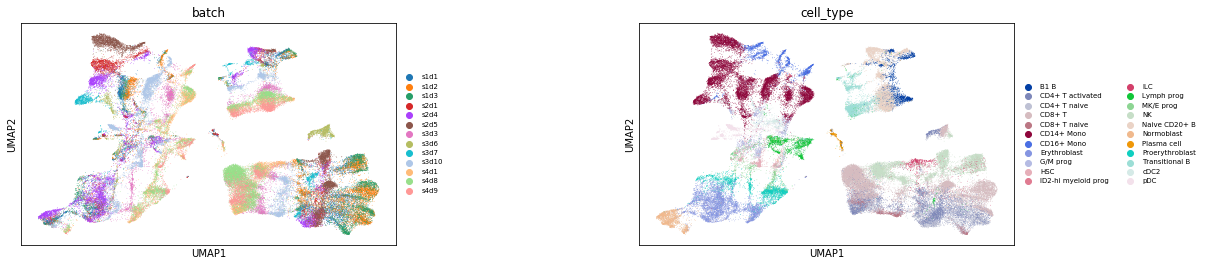

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_15.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_20.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



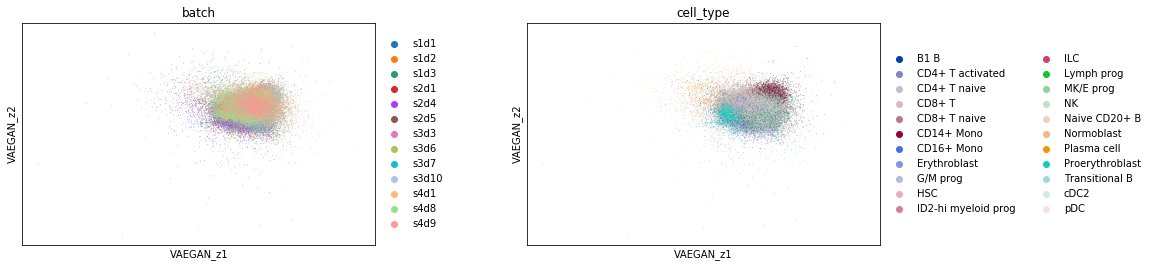

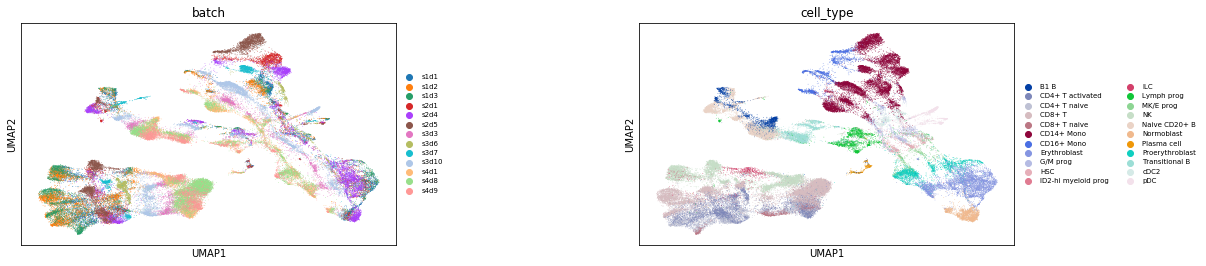

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_20.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

Loading checkpoint /content/gdrive/MyDrive/scintegration/checkpoints/VAEGAN_epoch_30.pt for model VAEGAN(
  (encoder): encoder(
    (efc1): Linear(in_features=13431, out_features=128, bias=True)
    (efc2): Linear(in_features=128, out_features=128, bias=True)
    (efc3_mu): Linear(in_features=128, out_features=16, bias=True)
    (efc3_sigma): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): decoder(
    (dfc1): Linear(in_features=16, out_features=128, bias=True)
    (dfc2): Linear(in_features=128, out_features=128, bias=True)
    (dfc3): Linear(in_features=128, out_features=13431, bias=True)
  )
  (classifier): classifier(
    (cfc1): Linear(in_features=16, out_features=20, bias=True)
    (cfc2): Linear(in_features=20, out_features=1, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



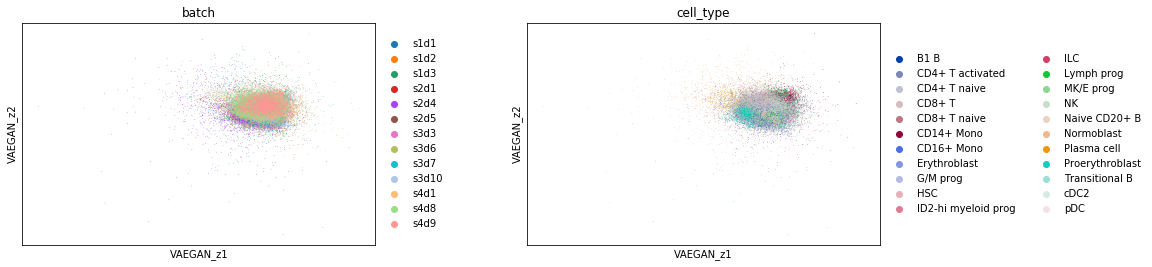

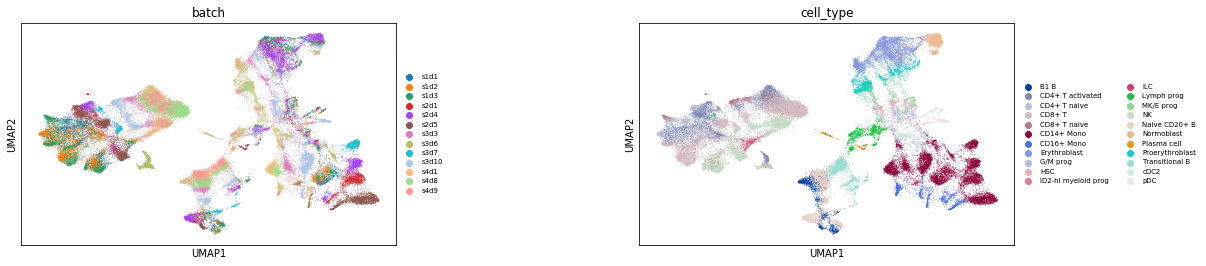

In [ ]:
VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_30.pt'))
VAEGAN.eval()
embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
scdata.obsm["VAEGAN_z"] = embeddings
sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], wspace=0.5, legend_fontsize = 'x-small')

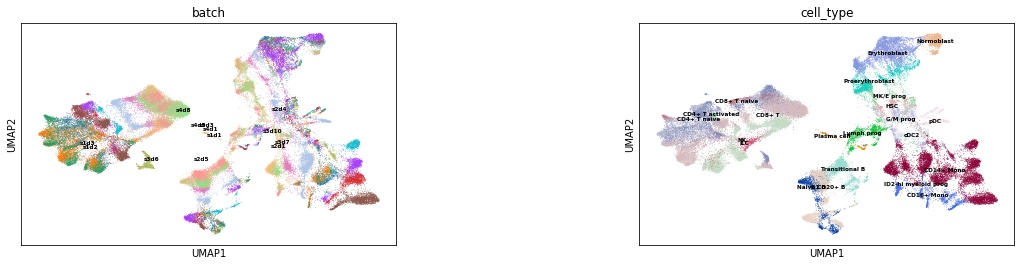

In [ ]:
# VEAGAN = load_checkpoint(VAEGAN, os.path.join(checkpoints, 'VAEGAN_epoch_90.pt'))
# VAEGAN.eval()
# embeddings, labels = get_embeddings(VAEGAN, GEX_dataloader_test,  device = device)
# scdata.obsm["VAEGAN_z"] = embeddings
# sc.pl.embedding(scdata, basis="VAEGAN_z", color=["batch", "cell_type"], wspace=0.3)
# sc.tl.umap(scdata, min_dist=0.3)
# sc.pp.neighbors(scdata, use_rep="VAEGAN_z")
sc.pl.umap(scdata, color=["batch", "cell_type"], legend_loc = "on data", wspace=0.5, legend_fontsize = 'xx-small')

In [ ]:
#visualise the loss for each of the three networks
def visualise_loss(vae_loss_list, classifier_loss_list, encoder_ad_loss_list):
    plt.figure(figsize=(10, 5))
    plt.title("VAE Loss")
    plt.plot(vae_loss_list)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.title("Classifier Loss")
    plt.plot(classifier_loss_list)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.figure(figsize=(10, 5))
    plt.title("Encoder Adversarial Loss")
    plt.plot(encoder_ad_loss_list)
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()
    
    

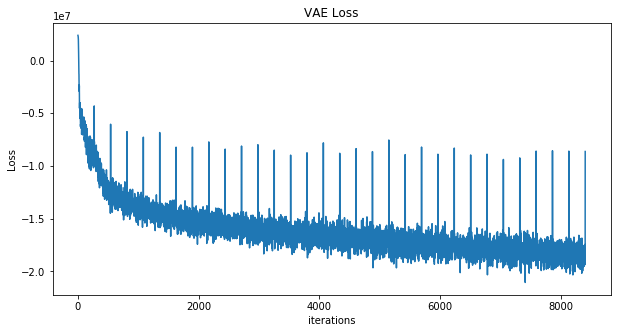

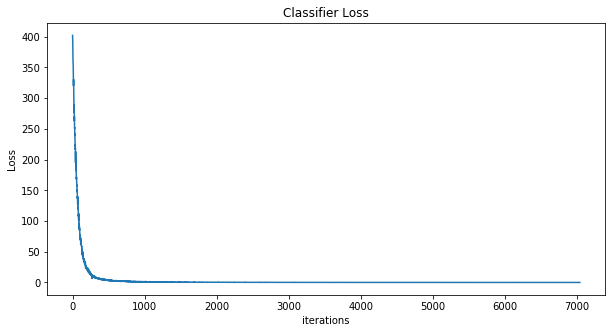

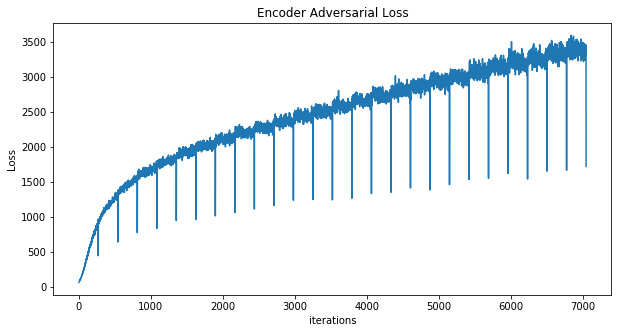

In [ ]:
visualise_loss(vae_loss_list, classifier_loss_list, encoder_ad_loss_list)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



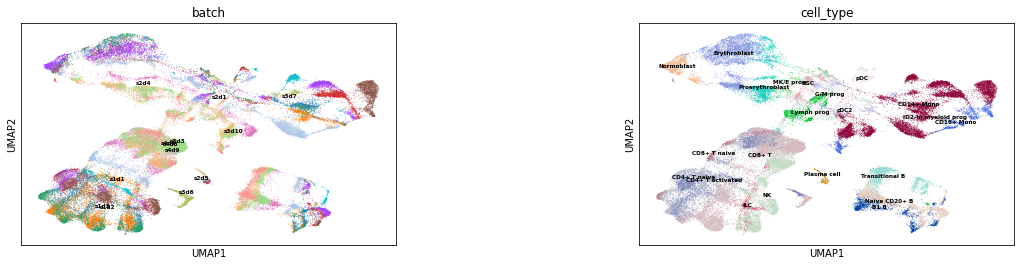

In [ ]:
def decode_embeddings(VAEGAN, embeddings):
    with torch.no_grad():
        embeddings = torch.tensor(embeddings).to(device)
        x_gen = VAEGAN.decoder.decode(embeddings)
        return x_gen.cpu().numpy()
scdata.obsm["VAEGAN_x_hat"] = decode_embeddings(VAEGAN, embeddings)
sc.pp.neighbors(scdata, use_rep="VAEGAN_x_hat", n_neighbors=30)
sc.tl.umap(scdata, min_dist=0.3)
sc.pl.umap(scdata, color=["batch", "cell_type"], legend_loc = "on data", wspace=0.5, legend_fontsize = 'xx-small')

SyntaxError: ignored